In [1]:
# https://www.biblesupersearch.com/bible-downloads/
# La Bible de l'Épée

In [2]:
# !wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [3]:
# conda install numpy pandas nltk matplotlib seaborn wordcloud scikit-learn tensorflow tensorflow-hub openpyxl
# !pip install tokenization

In [4]:
import numpy as np
import pandas as pd
import nltk
# nltk.download('stopwords')
# nltk.download('punkt
# nltk.download('wordnet')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from collections import Counter, defaultdict
import tokenization
import string

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

import operator

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

import gc

In [5]:
df = pd.read_excel('French_Bible.xlsx', header=5)

df

,Verse ID,Book Name,Book Number,Chapter,Verse,Text
0,1,Genèse,1,1,1,"¶ Dieu, au commencement, créa les cieux et la ..."
1,2,Genèse,1,1,2,"en une masse fluide et sans forme, et les ténè..."
2,3,Genèse,1,1,3,¶ Et Dieu dit: Que la lumière soit; et son ray...
3,4,Genèse,1,1,4,Et Dieu vit que la lumière était gracieuse; et...
4,5,Genèse,1,1,5,Et Dieu invita la lumière gracieuse; mais il c...
...,...,...,...,...,...,...
31097,31098,Apocalypse,66,22,17,L'Esprit et l'Épouse disent: Viens. Que celui ...
31098,31099,Apocalypse,66,22,18,Je proteste à quiconque entend les paroles de ...
31099,31100,Apocalypse,66,22,19,Et si quelqu'un retranche des paroles du livre...
31100,31101,Apocalypse,66,22,20,"¶ Celui qui rend témoignage de ces choses, dit..."


In [6]:
df = pd.read_excel('French_Bible.xlsx', header=5)

df

,Verse ID,Book Name,Book Number,Chapter,Verse,Text
0,1,Genèse,1,1,1,"¶ Dieu, au commencement, créa les cieux et la ..."
1,2,Genèse,1,1,2,"en une masse fluide et sans forme, et les ténè..."
2,3,Genèse,1,1,3,¶ Et Dieu dit: Que la lumière soit; et son ray...
3,4,Genèse,1,1,4,Et Dieu vit que la lumière était gracieuse; et...
4,5,Genèse,1,1,5,Et Dieu invita la lumière gracieuse; mais il c...
...,...,...,...,...,...,...
31097,31098,Apocalypse,66,22,17,L'Esprit et l'Épouse disent: Viens. Que celui ...
31098,31099,Apocalypse,66,22,18,Je proteste à quiconque entend les paroles de ...
31099,31100,Apocalypse,66,22,19,Et si quelqu'un retranche des paroles du livre...
31100,31101,Apocalypse,66,22,20,"¶ Celui qui rend témoignage de ces choses, dit..."


In [7]:
df_aux = pd.read_excel('French_Bible_Information.xlsx')

df_aux

,Book,Tanakh,King James Version,New Jerusalem Version,Time,Period,Location
0,Acts,NaN,44.0,51,80,Christian,Rome
1,Amos,17.0,30.0,37,-745,Monarchic,Israel
2,Baruch,NaN,NaN,32,-180,Hellenistic,Israel
3,1 Chronicles,38.0,13.0,13,-350,Persian,Israel
4,2 Chronicles,39.0,14.0,14,-350,Persian,Israel
...,...,...,...,...,...,...,...
68,Titus,NaN,56.0,63,100,Christian,Nicopolis
69,Tobit,NaN,NaN,17,-200,Hellenistic,Israel
70,Wisdom,NaN,NaN,27,-50,Maccabean,Israel
71,Zechariah,25.0,38.0,45,-500,Persian,Israel


In [8]:
sw = stopwords.words('french')

sw[:5]

['au', 'aux', 'avec', 'ce', 'ces']

In [9]:
matthieu = df[df['Book Name'] == 'Matthieu'].iloc[0]

matthieu

Verse ID                                                   23146
Book Name                                               Matthieu
Book Number                                                   40
Chapter                                                        1
Verse                                                          1
Text           ¶ Livre généalogique de JÉSUS-CHRIST, fils de ...
Name: 23145, dtype: object

In [10]:
df['Testament'] = ''

df.loc[df.index < 23145, 'Testament'] = 'Ancien'
df.loc[df.index >= 23145, 'Testament'] = 'Nouveau'

df

,Verse ID,Book Name,Book Number,Chapter,Verse,Text,Testament
0,1,Genèse,1,1,1,"¶ Dieu, au commencement, créa les cieux et la ...",Ancien
1,2,Genèse,1,1,2,"en une masse fluide et sans forme, et les ténè...",Ancien
2,3,Genèse,1,1,3,¶ Et Dieu dit: Que la lumière soit; et son ray...,Ancien
3,4,Genèse,1,1,4,Et Dieu vit que la lumière était gracieuse; et...,Ancien
4,5,Genèse,1,1,5,Et Dieu invita la lumière gracieuse; mais il c...,Ancien
...,...,...,...,...,...,...,...
31097,31098,Apocalypse,66,22,17,L'Esprit et l'Épouse disent: Viens. Que celui ...,Nouveau
31098,31099,Apocalypse,66,22,18,Je proteste à quiconque entend les paroles de ...,Nouveau
31099,31100,Apocalypse,66,22,19,Et si quelqu'un retranche des paroles du livre...,Nouveau
31100,31101,Apocalypse,66,22,20,"¶ Celui qui rend témoignage de ces choses, dit...",Nouveau


In [11]:
df_enriched = df_aux.drop(['Tanakh','New Jerusalem Version'], axis=1)
df_enriched['King James Version'] = df_enriched['King James Version'].replace(np.nan, 0)
df_enriched['King James Version'] = df_enriched['King James Version'].astype('int')
df_enriched = df_enriched.rename(columns={'Book': 'Book_Name'})

df_enriched

,Book_Name,King James Version,Time,Period,Location
0,Acts,44,80,Christian,Rome
1,Amos,30,-745,Monarchic,Israel
2,Baruch,0,-180,Hellenistic,Israel
3,1 Chronicles,13,-350,Persian,Israel
4,2 Chronicles,14,-350,Persian,Israel
...,...,...,...,...,...
68,Titus,56,100,Christian,Nicopolis
69,Tobit,0,-200,Hellenistic,Israel
70,Wisdom,0,-50,Maccabean,Israel
71,Zechariah,38,-500,Persian,Israel


In [12]:
df = df.merge(df_enriched, left_on='Book Number', right_on='King James Version')

df

,Verse ID,Book Name,Book Number,Chapter,Verse,Text,Testament,Book_Name,King James Version,Time,Period,Location
0,1,Genèse,1,1,1,"¶ Dieu, au commencement, créa les cieux et la ...",Ancien,Genesis,1,-500,Persian,Israel
1,2,Genèse,1,1,2,"en une masse fluide et sans forme, et les ténè...",Ancien,Genesis,1,-500,Persian,Israel
2,3,Genèse,1,1,3,¶ Et Dieu dit: Que la lumière soit; et son ray...,Ancien,Genesis,1,-500,Persian,Israel
3,4,Genèse,1,1,4,Et Dieu vit que la lumière était gracieuse; et...,Ancien,Genesis,1,-500,Persian,Israel
4,5,Genèse,1,1,5,Et Dieu invita la lumière gracieuse; mais il c...,Ancien,Genesis,1,-500,Persian,Israel
...,...,...,...,...,...,...,...,...,...,...,...,...
31097,31098,Apocalypse,66,22,17,L'Esprit et l'Épouse disent: Viens. Que celui ...,Nouveau,Revelation,66,95,Christian,Patmos
31098,31099,Apocalypse,66,22,18,Je proteste à quiconque entend les paroles de ...,Nouveau,Revelation,66,95,Christian,Patmos
31099,31100,Apocalypse,66,22,19,Et si quelqu'un retranche des paroles du livre...,Nouveau,Revelation,66,95,Christian,Patmos
31100,31101,Apocalypse,66,22,20,"¶ Celui qui rend témoignage de ces choses, dit...",Nouveau,Revelation,66,95,Christian,Patmos


In [13]:
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize
import string

def lower_column_t(series):
    return series.str.lower()

def clean_interpunction(series):
    return series.str.replace('[{}]'.format(string.punctuation), '')

def lem(a):
    lemmatizer = WordNetLemmatizer()
    b = []
    for line in a:
        tokens = word_tokenize(line)
        lem_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in sw]
        b.append(' '.join(lem_tokens))
    return b

def stem(a):
    stemmer = FrenchStemmer()
    return [stemmer.stem(word) for word in a]

def tokenize(a):  
    return [word_tokenize(line, language='french') for line in a]

def flatten(a):
    return [' '.join(line) for line in a]

def count_words(a):
    return sum([sum(1 for i in line if i.strip(string.punctuation).isalpha()) for line in a])

def generate_ngrams(text, n_gram=1):
    tokens = [token for token in text.lower().split(' ') if token != '']
    return [' '.join(tokens[i:i+n_gram]) for i in range(len(tokens) - n_gram + 1)]

In [14]:
df['Text'] = lower_column_t(df['Text'])
df['Text'] = clean_interpunction(df['Text'])
df['Text_Lem'] = lem(df['Text'])
df['Text_Stem'] = stem(df['Text'])
df['Text_Stem_Lem'] = lem(df['Text_Stem'])
df['No Words'] = df['Text'].str.split().str.len()
# df=df.set_index('id')

df

,Verse ID,Book Name,Book Number,Chapter,Verse,Text,Testament,Book_Name,King James Version,Time,Period,Location,Text_Lem,Text_Stem,Text_Stem_Lem,No Words
0,1,Genèse,1,1,1,"¶ dieu, au commencement, créa les cieux et la ...",Ancien,Genesis,1,-500,Persian,Israel,"¶ dieu , commencement , créa cieux terre ;","¶ dieu, au commencement, créa les cieux et la ...","¶ dieu , commencement , créa cieux terre ;",10
1,2,Genèse,1,1,2,"en une masse fluide et sans forme, et les ténè...",Ancien,Genesis,1,-500,Persian,Israel,"masse fluide sans forme , ténèbres surface l'e...","en une masse fluide et sans forme, et les ténè...","masse fluide sans forme , ténèbres surface l'e...",25
2,3,Genèse,1,1,3,¶ et dieu dit: que la lumière soit; et son ray...,Ancien,Genesis,1,-500,Persian,Israel,¶ dieu dit : lumière ; rayonnement .,¶ et dieu dit: que la lumière soit; et son ray...,¶ dieu dit : lumière ; rayonnement .,12
3,4,Genèse,1,1,4,et dieu vit que la lumière était gracieuse; et...,Ancien,Genesis,1,-500,Persian,Israel,dieu vit lumière gracieuse ; dieu démêla lumiè...,et dieu vit que la lumière était gracieuse; et...,dieu vit lumière gracieuse ; dieu démêla lumiè...,16
4,5,Genèse,1,1,5,et dieu invita la lumière gracieuse; mais il c...,Ancien,Genesis,1,-500,Persian,Israel,dieu invita lumière gracieuse ; convoqua ténèb...,et dieu invita la lumière gracieuse; mais il c...,dieu invita lumière gracieuse ; convoqua ténèb...,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31097,31098,Apocalypse,66,22,17,l'esprit et l'épouse disent: viens. que celui ...,Nouveau,Revelation,66,95,Christian,Patmos,l'esprit l'épouse disent : viens . celui l'ent...,l'esprit et l'épouse disent: viens. que celui ...,l'esprit l'épouse disent : viens . celui l'ent...,29
31098,31099,Apocalypse,66,22,18,je proteste à quiconque entend les paroles de ...,Nouveau,Revelation,66,95,Christian,Patmos,proteste quiconque entend parole prophétie liv...,je proteste à quiconque entend les paroles de ...,proteste quiconque entend parole prophétie liv...,29
31099,31100,Apocalypse,66,22,19,et si quelqu'un retranche des paroles du livre...,Nouveau,Revelation,66,95,Christian,Patmos,si quelqu'un retranche parole livre cette prop...,et si quelqu'un retranche des paroles du livre...,si quelqu'un retranche parole livre cette prop...,33
31100,31101,Apocalypse,66,22,20,"¶ celui qui rend témoignage de ces choses, dit...",Nouveau,Revelation,66,95,Christian,Patmos,"¶ celui rend témoignage choses , dit : oui , v...","¶ celui qui rend témoignage de ces choses, dit...","¶ celui rend témoignage choses , dit : oui , v...",18


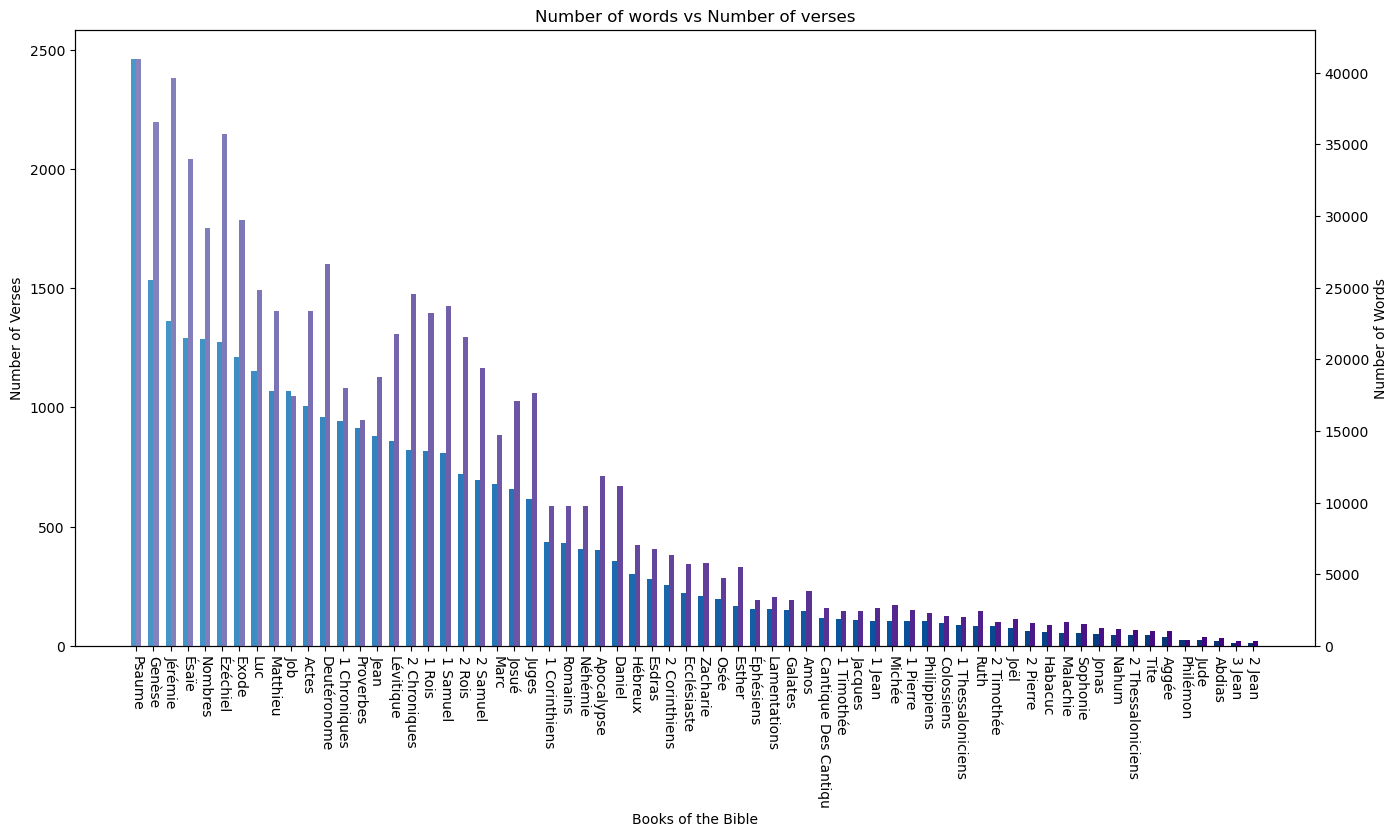

In [15]:
color_1 = plt.cm.Blues(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, 66))

verse_words = df.groupby('Book Name').agg({'Book Number':'count','No Words':'sum'}).sort_values(by='Book Number',ascending=False)
data1 = verse_words['Book Number']
data2 = verse_words['No Words']

plt.figure(figsize=(16,8))
x = np.arange(66)
ax1 = plt.subplot(1,1,1)
w = 0.3

color = color_1
plt.title('Number of words vs Number of verses')
plt.xticks(x + w / 2, data1.index, rotation=-90)
ax1.set_xlabel('Books of the Bible')
ax1.set_ylabel('Number of Verses')
ax1.bar(x,data1.values,color=color_1,width=w,align='center')

ax2 = ax1.twinx()

color = color_2
ax2.set_ylabel('Number of Words')
ax2.bar(x + w,data2, color=color_2,width=w,align='center')

plt.show()

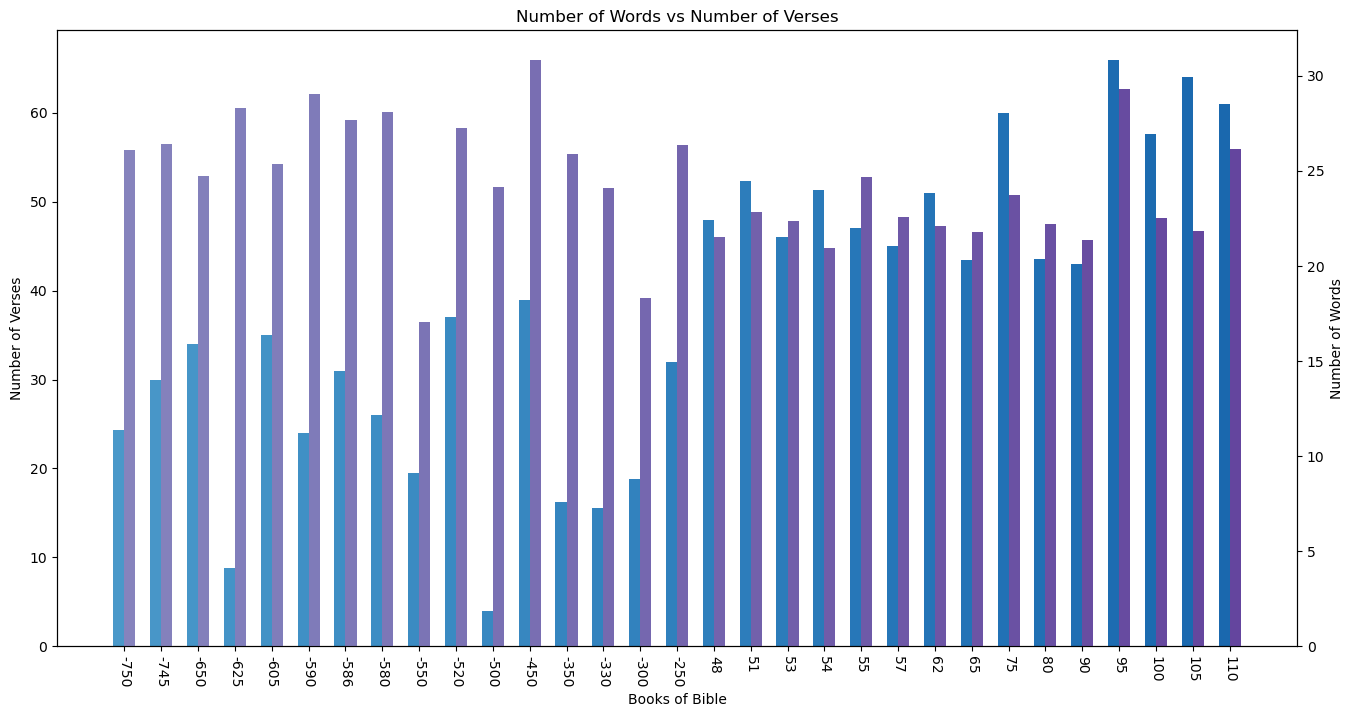

In [16]:
color_1 = plt.cm.Blues(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, 66))

verse_words_ = df.groupby('Time').agg({'Book Number':'mean','No Words':'mean','Time':'mean'})
data1 = verse_words_['Book Number']
data2 = verse_words_['No Words']

plt.figure(figsize=(16,8))
x = np.arange(31)
ax1 = plt.subplot(1,1,1)
w = 0.3

color = color_1
plt.title('Number of Words vs Number of Verses')
plt.xticks(x + w / 2, data1.index, rotation=-90)
ax1.set_xlabel('Books of Bible')
ax1.set_ylabel('Number of Verses')
ax1.bar(x,data1.values,color=color_1,width=w,align='center')

ax2 = ax1.twinx()

color = color_2
ax2.set_ylabel('Number of Words')
ax2.bar(x + w,data2, color=color_2,width=w,align='center')

plt.show()

In [20]:
verse_words['Verse Length'] = round(verse_words['No Words'] / verse_words['Book Number'], 0)
verse_words = verse_words.sort_values(by='Verse Length', ascending=False)
df_enriched_to_merge = df_enriched.set_index('Book Name')
verse_words = verse_words.merge(df_enriched_to_merge, left_index=True, right_index=True)

SpearmanCorr = verse_words[['No Words', 'Time', 'Verse Length']].corr(method="spearman")
plt.figure(figsize=(7, 7))
sns.heatmap(SpearmanCorr, vmax=.9, square=True, annot=True, linewidths=.3, cmap="YlGnBu", fmt='.1f')

KeyError: "None of ['Book Name'] are in the columns"